In [ ]:
#Import the libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/DL/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
len(os.listdir('/tmp/Negative/'))

20000

In [ ]:
len(os.listdir('/tmp/Positive/'))

20000

In [ ]:
positive_dir = Path('/tmp/Positive/')
negative_dir = Path('/tmp/Negative/')

In [ ]:
#make dataframes
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/tmp/Positive/06256.jpg,POSITIVE
1,/tmp/Positive/16496_1.jpg,POSITIVE
2,/tmp/Positive/00076.jpg,POSITIVE
3,/tmp/Negative/02150.jpg,NEGATIVE
4,/tmp/Positive/02862.jpg,POSITIVE
...,...,...
39995,/tmp/Positive/06364.jpg,POSITIVE
39996,/tmp/Negative/14166.jpg,NEGATIVE
39997,/tmp/Positive/00687.jpg,POSITIVE
39998,/tmp/Positive/18894_1.jpg,POSITIVE


In [ ]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [ ]:
#load data
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
#train
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 19s 52ms/step - loss: 0.6704 - accuracy: 0.6455 - val_loss: 0.6411 - val_accuracy: 0.6786
Epoch 2/100
105/105 [==============================] - 5s 49ms/step - loss: 0.5917 - accuracy: 0.7301 - val_loss: 0.5757 - val_accuracy: 0.6417
Epoch 3/100
105/105 [==============================] - 5s 49ms/step - loss: 0.5118 - accuracy: 0.8033 - val_loss: 0.4616 - val_accuracy: 0.8464
Epoch 4/100
105/105 [==============================] - 5s 49ms/step - loss: 0.3992 - accuracy: 0.8929 - val_loss: 0.3797 - val_accuracy: 0.8786
Epoch 5/100
105/105 [==============================] - 5s 49ms/step - loss: 0.3196 - accuracy: 0.9190 - val_loss: 0.3275 - val_accuracy: 0.9012
Epoch 6/100
105/105 [==============================] - 7s 64ms/step - loss: 0.2652 - accuracy: 0.9417 - val_loss: 0.3019 - val_accuracy: 0.8798
Epoch 7/100
105/105 [==============================] - 7s 63ms/step - loss: 0.2140 - accuracy: 0.9515 - val_loss: 0.2242 - val_accuracy

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [ ]:
#results
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.07566
Test Accuracy: 97.78%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



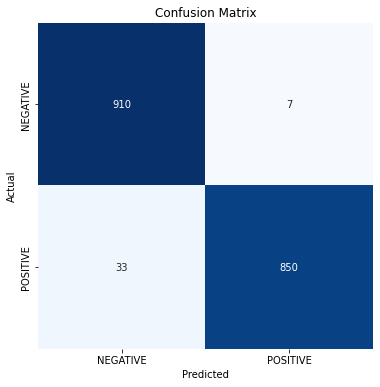

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       917
    POSITIVE       0.99      0.96      0.98       883

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [ ]:
evaluate_model(model, test_data)

In [ ]:
#predict with 1 picture
from keras.preprocessing import image
img=image.load_img('/tmp/Negative/00001.jpg',target_size=(120,120))

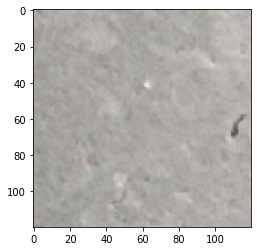

In [ ]:
plt.imshow(img)

In [ ]:
img1=image.img_to_array(img)
img1=img1/255

In [ ]:
img1=np.expand_dims(img1,[0])
print(img1.shape)

(1, 120, 120, 3)


In [ ]:
pred=model.predict(img1)
if(pred[0]>=0.5):
    print("Crack Detected")
else:
    print("No Crack Detected")

No Crack Detected


In [ ]:
pred

array([[0.0477768]], dtype=float32)

In [ ]:
#make a web app using gradio
!pip install gradio
import gradio as gr
import cv2
#creating the interface
def classify(image):
    image = np.array(image)
    image = cv2.resize(image, (120, 120))
    image = image.reshape(1, 120, 120, 3)
    image = image/255.0
    prediction = model.predict(image)
    if prediction[0]>=0.5:
        return 'Crack'
    else:
        return 'No Crack'

#creating the web app
interface = gr.Interface(classify, gr.inputs.Image(), gr.outputs.Label())

#launching the web app
interface.launch()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 929 kB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 212 kB 73.3 MB/s 
     |████████████████████████████████| 270 kB 73.1 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 112 kB 69.1 MB/s 
     |████████████████████████████████| 55 kB 1.3 MB/s 
     |████████████████████████████████| 2.3 MB 52.8 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 54 kB 3.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 80 kB 10.6 MB/s 
     |████████████████████████████████| 68 kB 7.8 MB/s 
     |████████████████████████████████| 46 kB 4.0 MB/s 
     |████████████████████████████████| 594 kB 73.6 MB/s 
     |████████████████████████████████| 4.0 MB 53

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning:

Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning:

`optional` parameter is deprecated, and it has no effect

/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning:

Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning:

The 'type' parameter has been deprecated. Use the Number component instead.



Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://29159.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fc77e6b58d0>,
 'http://127.0.0.1:7860/',
 'https://29159.gradio.app')